In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# How SAFE encoding works?

The intuition behind safe is quite simple: we want to represent any molecule as a  `set of connected fragments`.

## Preliminary on SMILES.

Let's start first by revisiting some information about the SMILES syntax:

- **An asterisk `*` in a smiles is usually employed to indicate any atom OR an attachment point of any group. It's particularly useful for smarts matching.**

- **Number in smiles syntax indicates connectivity points between two atoms. For 2 digits numbers they would need to be preceeded by `%`**. 

This is partially explained on the wikipedia [ring section of SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Rings).

- **A dot `.` in smiles indicates the presence of additional fragments and is used to separate them**. 

A good ressource on the subject is the [DAYLIGHT page](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html).

We illustrate these informations below !

In [1]:
import datamol as dm

from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdChemReactions as rdr
rdDepictor.SetPreferCoordGen(True)


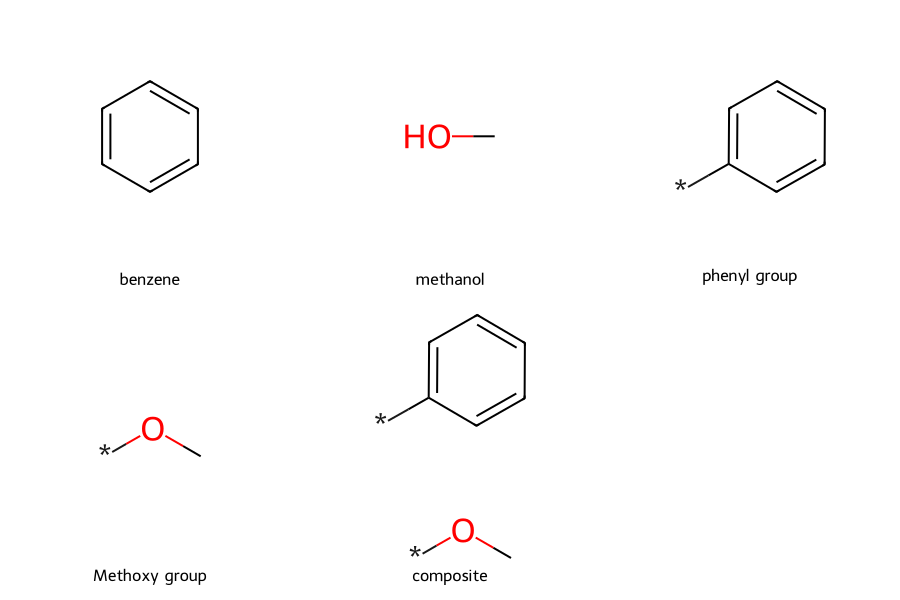

In [2]:
smiles = ["c1ccccc1", "OC", "c1cc(*)ccc1", "O(*)C", "c1cc(*)ccc1.O(*)C"]
legends = ["benzene", "methanol", "phenyl group", "Methoxy group", "composite"]
dm.viz.to_image([dm.to_mol(x) for x in smiles], legends=legends, n_cols=3, use_svg=True)


In the example above, we can see that `phenol` can be represented as two fragments that can be connected given proper attachment point. 

To achieve this we are interested in attaching 2 fragments together (the `methoxy` and the `phenyl` groups). In RDKit, this can usually be achieved using chemical reactions. For convenience, we will prefer a standardized representation of attachment points that includes an atom mapping.

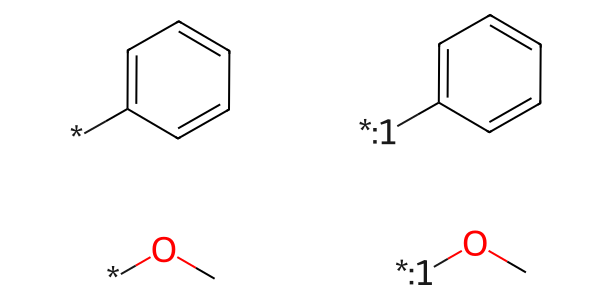

In [3]:
smiles = [ 'c1cc(*)ccc1.O(*)C', 'c1cc([*:1])ccc1.O([*:1])C'] #
dm.viz.to_image([dm.to_mol(x) for x in smiles], n_cols=len(smiles), use_svg=True)


To attach the two fragments, I can write a simple chemical transformation. Since smarts and smiles syntax do not mix very well when it comes to `*` I will assume an isotopic representation `[1*]` instead of `[*:1]`


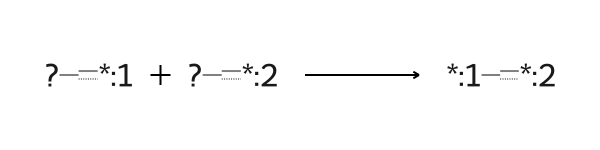

In [4]:
rxn = rdr.ReactionFromSmarts("[1*][*:1].[1*][*:2]>>[*:1][*:2]")
rxn


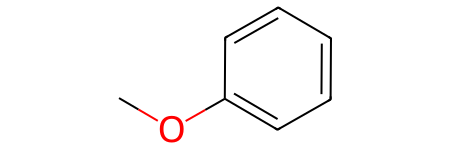

In [5]:
# replace atom map by isotopes
phenyl = "c1cc([*:1])ccc1".replace("[*:1]", "[1*]")
methoxy = "O([*:1])C".replace("[*:1]", "[1*]")

# runreactions
prod = rxn.RunReactants((dm.to_mol(phenyl), dm.to_mol(methoxy)))
prod[0][0]


We can achieve the same result by using rdkit API in an slightly more tedious way.


[11:14:08] WARNING: not removing hydrogen atom without neighbors


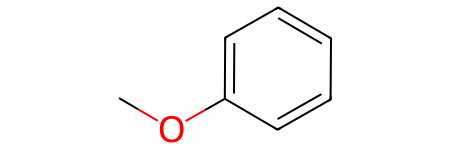

In [6]:
replacement_sub =  Chem.MolFromSmarts("[1*]")
prod = Chem.ReplaceSubstructs(dm.to_mol(phenyl), replacement_sub, dm.to_mol(methoxy), replacementConnectionPoint=0)
prod = dm.remove_dummies(prod[0], dummy="[1*]")
prod


But wait, could we attach the fragment using only the string operations on the smiles ?

Well, it's not possible by trying to perform substring replacement, but recall we just said that `numbers in smiles represents connectivity points` ?

In [7]:
phenyl = "c1cc([*:1])ccc1"
methoxy = "O([*:1])C"
composite = phenyl + "." + methoxy # c1cc([*:1])ccc1.O([*:1])C
compo = dm.to_mol(composite)


Since `1` "connectivity point" is already present in the phenyl group. We need to start by opening a new connectivity point: `2`

In [8]:
attached_composite = composite.replace("[*:1]", "2")
dm.to_mol(attached_composite)


[11:14:10] SMILES Parse Error: syntax error while parsing: c1cc(2)ccc1.O(2)C
[11:14:10] SMILES Parse Error: Failed parsing SMILES 'c1cc(2)ccc1.O(2)C' for input: 'c1cc(2)ccc1.O(2)C'


The previous line does not work because of violation in the smiles syntax. As we are not taking into account the branching bracket surrounding the attachment point.

We could try to regenerate the smiles or scan the sequence and remove the brackets when it's possible, but we want to limit the operations to `str.replace`. So let's try again.

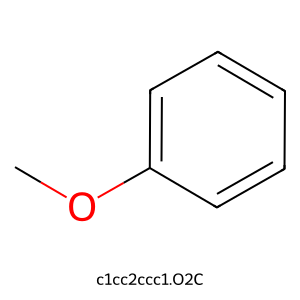

In [9]:
attached_composite = composite.replace("([*:1])", "2").replace("[*:1]", "2")
dm.to_image(attached_composite, legends=[attached_composite])


You can see that the phenol molecule is represented as two "fragments" `[Fragment1].[Fragment2]`. That is what SAFE is about.

In summary, to build a SAFE string, we just need to follow the step below:

![safe](../assets/safe-construction.svg)

---

The End !